In [1]:
# Import Important Libraries
library(arcgisbinding)
arc.check_product()

*** Please call arc.check_product() to define a desktop license.


product: ArcGIS Pro (13.0.2.36056)
license: Advanced
version: 1.0.1.300

In [3]:
library(agricolae)
library(dplyr)
library(scales)
library(ggplot2)
library(tidyverse)

# Load Data from ArcGIS Pro

In [16]:
# Fetching shapefile
dataset_2022 <- arc.open('C:/Users/abe_lizbethp/OneDrive - Iowa State University/Documents/2022_Data_Analysis/data_analysis_v2/data_analysis_v2.gdb/Digital_Acre_2022')
# Saving as dataframe
field <- c("Core_ID", "Rep", "ElevClass","Elev_Categ", "T_Name", "PostErrorC", "OnFieldJ", "WetWt2", "SkipBowl")
da_2022.df <- arc.select(dataset_2022, fields = field)

## Filtering Data

In [17]:
filtered_data <- da_2022.df %>% filter(T_Name != 'Depth Shallow' &
                     !is.na(SkipBowl))

# Run Statistical Models - Overall Skip Bowl Effect

In [18]:
# One-way ANOVA
skb_model <- aov(WetWt2~SkipBowl, data = filtered_data)
summary(skb_model)

               Df    Sum Sq Mean Sq F value   Pr(>F)    
SkipBowl        1    285635  285635   43.18 5.12e-11 ***
Residuals   18612 123107492    6614                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [19]:
vec <- c('1','2','3','4','5','6','7','-1')
# Fisher’s Least Significant Difference (LSD) Test
skb_lsd<-LSD.test(skb_model, "SkipBowl", alpha = 0.05)
skb_lsd_df <- as.data.frame(skb_lsd$groups)  %>% 
    rownames_to_column(var = "SkipBowl")
skb_lsd_df <- skb_lsd_df[match(vec, skb_lsd_df$SkipBowl), ]


In [20]:
skb_lsd_df

,SkipBowl,WetWt2,groups
1,1,257.0458,a
2,2,240.5078,b
3,3,228.3694,c
4,4,218.4945,d
7,5,207.5988,ef
5,6,210.8262,e
6,7,209.5548,ef
8,-1,205.5658,f


In [111]:
#join_data <- left_join(filtered_data, skb_lsd_df, by = 'SkipBowl')b

# Plotting Skip Bowl Effect

In [21]:
DeereTheme <-   theme(
  plot.title = element_text(size=28, hjust = 0.5, face = "bold", margin = margin(b = 15)),
  plot.subtitle = element_text(size=26, hjust = 0.5, face = "plain", margin = margin(b = 20)),
  axis.title.x = element_text(size = 24, face = "bold", margin = margin(t = 40)),
  axis.title.y = element_text(size = 24, face = "bold", margin = margin(r = 40)),
  axis.text = element_text(size = 24, colour = "black"),
  plot.margin = margin(2,2,2,2,"cm"),
  plot.background = element_rect(fill = "gray79"),
  panel.background = element_rect(fill="white"),
  panel.grid.major=element_line(colour="gray91"),
  panel.grid.minor=element_line(colour="gray91"),
  panel.border = element_rect(colour = "black", fill=NA,size=2)
)

No summary function supplied, defaulting to `mean_se()


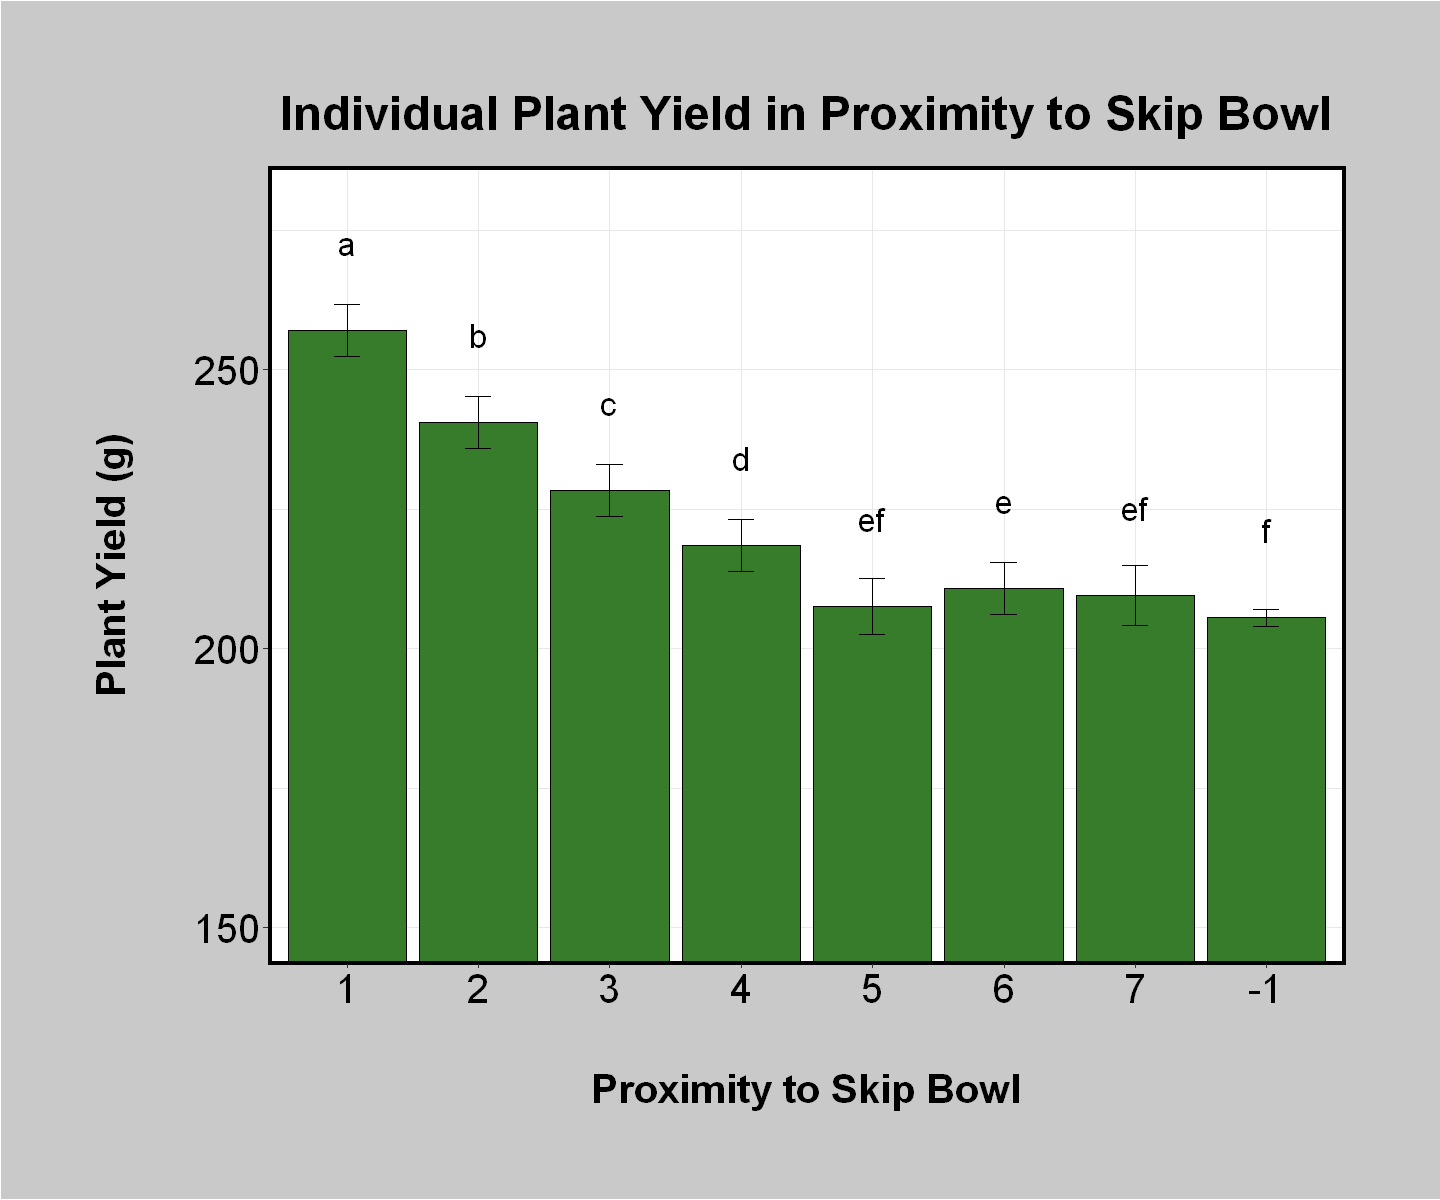

In [172]:
options(repr.plot.width =12, repr.plot.height =10)
filtered_data$SkipBowl <- factor(filtered_data$SkipBowl, levels = c(1,2,3,4,5,6,7,-1))
    ggplot(data=filtered_data, aes(x=SkipBowl, y = WetWt2)) +
    geom_bar(stat="summary", colour = "black", fill = "#367C2B") +
    geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, fun.args = list(mult = 1.96)) +
    scale_x_discrete(limits = c('1','2','3','4','5','6','7','-1')) +
    scale_y_continuous(limits = c(150,280), oob = rescale_none) +
    #stat_summary(data=skb_lsd_df, aes(x=index, y = groups), vjust = -3, size =7) +
    geom_text(data=skb_lsd_df,aes(label = groups), vjust = -3, size =7) +
    #stat_summary(geom = 'text', label = c("a", "b", "c","d", "ef","e","ef", "f"), vjust = -3, size =7) +
    xlab("Proximity to Skip Bowl") +
    ylab("Plant Yield (g)") +
    ggtitle("Individual Plant Yield in Proximity to Skip Bowl") +
    DeereTheme 

# Skip Bowl Effect by Elevation Class

In [180]:
# Function to generate skipb effect graph 
skb_effect <- function(sub_dataset,elev_cat) {
    # One-way ANOVA
    skb_model <- aov(WetWt2~SkipBowl, data = sub_dataset)
    vec <- c('1','2','3','4','5','6','7','-1')
    # Fisher’s Least Significant Difference (LSD) Test
    skb_lsd<-LSD.test(skb_model, "SkipBowl", alpha = 0.05)
    # LSD into dataframe 
    skb_lsd_df <- as.data.frame(skb_lsd$groups)  %>% 
        rownames_to_column(var = "SkipBowl")
    skb_lsd_df <- skb_lsd_df[match(vec, skb_lsd_df$SkipBowl), ]
    
    # Plot Data
    options(repr.plot.width =12, repr.plot.height =10)
    sub_dataset$SkipBowl <- factor(sub_dataset$SkipBowl, levels = c(1,2,3,4,5,6,7,-1))
    plt <- ggplot(data=sub_dataset, aes(x=SkipBowl, y = WetWt2)) +
    geom_bar(stat="summary", colour = "black", fill = "#367C2B") +
    geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, fun.args = list(mult = 1.96)) +
    scale_x_discrete(limits = c('1','2','3','4','5','6','7','-1')) +
    scale_y_continuous(limits = c(150,280), oob = rescale_none) +
    geom_label(data=skb_lsd_df,aes(label = groups),size =6, label.padding = unit(0.45, "lines")) +
    xlab("Proximity to Skip Bowl") +
    ylab("Plant Yield (g)") +
    ggtitle("Individual Plant Yield in Proximity to Skip Bowl", subtitle = paste('Elevation Category ', elev_cat)) +
    DeereTheme
    
    return(plt)
    
}

In [182]:
elev_category <- list('A','B','C','D','E')
for (x in elev_category){
    data_elev <- filtered_data %>% filter(Elev_Categ == x)
    elev_cat = x
    plt <- skb_effect(data_elev, elev_cat)
    png_name <- paste('skbeffect_elev_',x, '.png')
    ggsave(png_name, plot = plt, width = 12, height = 10)
}

No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()


# Skip Bowl Effect by Rep 

In [183]:
# Function to generate skipb effect graph 
skb_effect_rep <- function(sub_dataset,rep) {
    # One-way ANOVA
    skb_model <- aov(WetWt2~SkipBowl, data = sub_dataset)
    vec <- c('1','2','3','4','5','6','7','-1')
    # Fisher’s Least Significant Difference (LSD) Test
    skb_lsd<-LSD.test(skb_model, "SkipBowl", alpha = 0.05)
    # LSD into dataframe 
    skb_lsd_df <- as.data.frame(skb_lsd$groups)  %>% 
        rownames_to_column(var = "SkipBowl")
    skb_lsd_df <- skb_lsd_df[match(vec, skb_lsd_df$SkipBowl), ]
    
    # Plot Data
    options(repr.plot.width =12, repr.plot.height =10)
    sub_dataset$SkipBowl <- factor(sub_dataset$SkipBowl, levels = c(1,2,3,4,5,6,7,-1))
    plt <- ggplot(data=sub_dataset, aes(x=SkipBowl, y = WetWt2)) +
    geom_bar(stat="summary", colour = "black", fill = "#367C2B") +
    geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, fun.args = list(mult = 1.96)) +
    scale_x_discrete(limits = c('1','2','3','4','5','6','7','-1')) +
    scale_y_continuous(limits = c(150,280), oob = rescale_none) +
    geom_label(data=skb_lsd_df,aes(label = groups),size =6, label.padding = unit(0.45, "lines")) +
    xlab("Proximity to Skip Bowl") +
    ylab("Plant Yield (g)") +
    ggtitle("Individual Plant Yield in Proximity to Skip Bowl", subtitle = paste('Rep ', rep)) +
    DeereTheme
    
    return(plt)
    
}

In [188]:
for (x in list(1,2,3,4,5,6,7,8,9)) {
    data_rep <- filtered_data %>% filter(Rep == x)
    rep_num = x
    plt <- skb_effect_rep(data_rep, rep_num)
    png_name <- paste('skbeffect_rep_',x, '.png')
    ggsave(png_name, plot = plt, width = 12, height = 10)
}

No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()


In [ ]:
sub_dataset$WetWt3 <- sub_dataset$WetWt2/mean(sub_dataset$WetWt2)

# Skip Bowl Effect by Elevation Class

In [6]:
# Function to generate skipb effect graph 
skb_effect_class <- function(sub_dataset,eclass) {
    
    sub_dataset$WetWt3 <- sub_dataset$WetWt2/mean(sub_dataset$WetWt2)
    # One-way ANOVA
    skb_model <- aov(WetWt3~SkipBowl, data = sub_dataset)
    vec <- c('1','2','3','4','5','6','7','-1')
    # Fisher’s Least Significant Difference (LSD) Test
    skb_lsd<-LSD.test(skb_model, "SkipBowl", alpha = 0.05)
    # LSD into dataframe 
    skb_lsd_df <- as.data.frame(skb_lsd$groups)  %>% 
        rownames_to_column(var = "SkipBowl")
    skb_lsd_df <- skb_lsd_df[match(vec, skb_lsd_df$SkipBowl), ]
    
    # Plot Data
    options(repr.plot.width =12, repr.plot.height =10)
    sub_dataset$SkipBowl <- factor(sub_dataset$SkipBowl, levels = c(1,2,3,4,5,6,7,-1))
    
    plt <- ggplot(data=sub_dataset, aes(x=SkipBowl, y = WetWt3)) +
    geom_bar(stat="summary", colour = "black", fill = "#367C2B") +
    geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, fun.args = list(mult = 1.96)) +
    scale_x_discrete(limits = c('1','2','3','4','5','6','7','-1')) +
    scale_y_continuous(limits = c(0.5,1.3), oob = rescale_none) +
    geom_label(data=skb_lsd_df,aes(label = groups),size =6, label.padding = unit(0.45, "lines")) +
    geom_text(data=skb_lsd_df,aes(y = 0.7,label = round(WetWt3, 2)), size =6,  fontface = "bold") +
    xlab("Proximity to Skip Bowl") +
    ylab("Plant Yield (g)") +
    ggtitle("Individual Plant Yield in Proximity to Skip Bowl", subtitle = paste('Elevation Class ', eclass, ', Data Count ', nrow(sub_dataset))) +
    #annotate('text', x = 0, y = 0, label = 'text') +
    DeereTheme
    
    return(plt)
    
}

In [289]:
for (x in list(0,1,2,4,5,6,7,8)) {
    data_class <- filtered_data %>% filter(ElevClass == x)
    class_num = x
    plt <- skb_effect_class(data_class, class_num)
    png_name <- paste('skbeffect_perc_elev_class_',x, '.png')
    ggsave(png_name, plot = plt, width = 12, height = 10)
}

No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()


# Additional

[1] "skbeffect_perc_elev_class_ 8 .png"


No summary function supplied, defaulting to `mean_se()


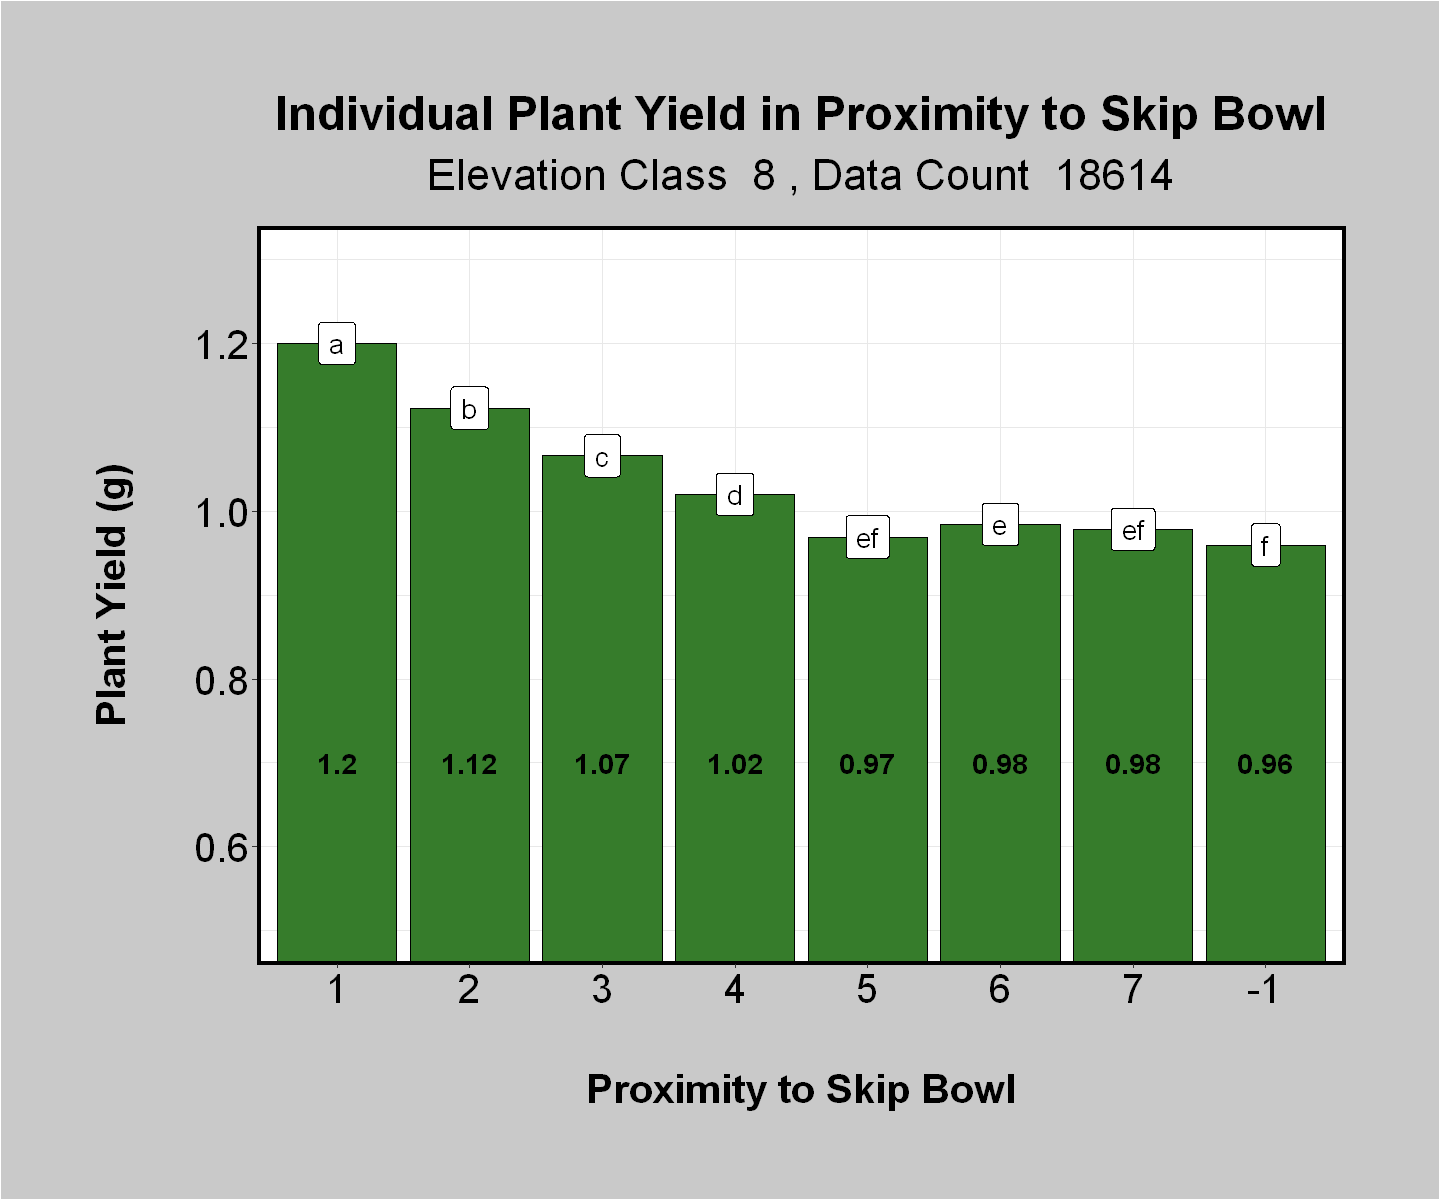

In [14]:
filtered_test <- da_2022.df %>% filter(T_Name != 'Depth Shallow' &
                     !is.na(SkipBowl))

#data_class <- filtered_test %>% filter(ElevClass == x)
class_num = x
plt <- skb_effect_class(filtered_test, class_num)
png_name <- paste('skbeffect_perc_elev_class_',x, '.png')
print(png_name)
print(plt)

[1] "skbeffect_perc_elev_class_ 8 .png"


No summary function supplied, defaulting to `mean_se()


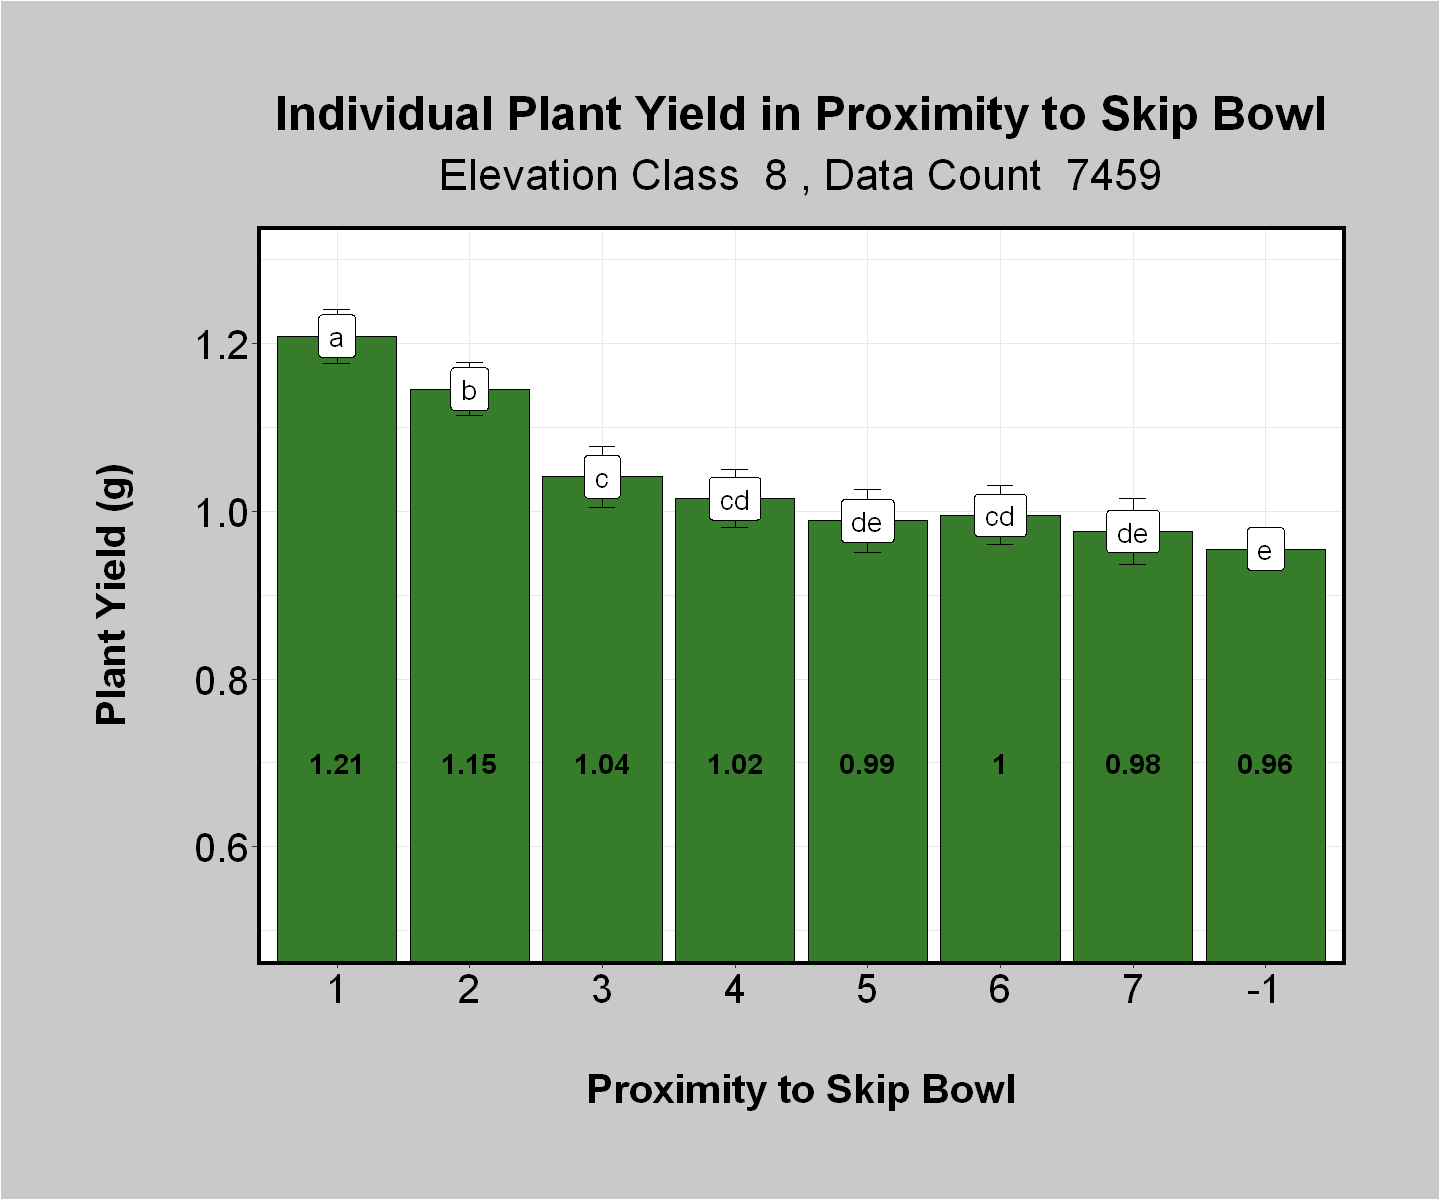

In [13]:
filtered_test <- da_2022.df %>% filter(T_Name == 'Control' &
                     !is.na(SkipBowl))

#data_class <- filtered_test %>% filter(ElevClass == x)
class_num = x
plt <- skb_effect_class(filtered_test, class_num)
png_name <- paste('skbeffect_perc_elev_class_',x, '.png')
print(png_name)
print(plt)